In [ ]:
"""
Created on 20190220

cnn using torch
"""

# Import 

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 數據
import matplotlib.pyplot as plt

# Data Preparation

## Load Data

In [2]:
# Load的時候就直接進行轉換
mnist = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
    #torchvision.transforms.ToTensor(), torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=False          # 没下载就下载, 下载了就不用再下了
)

mnist_train = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=None,    # 转换 PIL.Image or numpy.ndarray 成
    #torchvision.transforms.ToTensor(), torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=False          # 没下载就下载, 下载了就不用再下了
)

mnist_test = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=False,  # this is training data
    transform=None,    # 转换 PIL.Image or numpy.ndarray 成
    #torchvision.transforms.ToTensor(), torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=False          # 如果你已经下载好了mnist数据就写上 False
)

## Set DataLoader

In [3]:
# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001         
DOWNLOAD_MNIST = True

X_train, y_train = mnist_train.train_data, mnist_train.train_labels
X_test, y_test = mnist_test.test_data, mnist_test.test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# pytorch對這些資料前處理有提供更方便API (torchvision.transform.ToTensor())
X_train = torch.unsqueeze(X_train, dim=1)
X_train = X_train.type(torch.FloatTensor) #解決錯: _thnn_conv2d_forward is not implemented for type torch.ByteTensor
m = Data.TensorDataset(X_train / 255., y_train)

# for batch training - 50 samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=m, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(mnist_test.test_data, dim=1).type(torch.FloatTensor)[:2000] / 255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = mnist_test.test_labels[:2000]

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


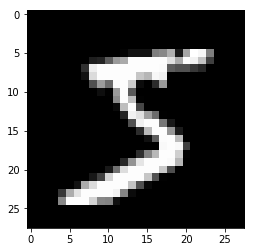

In [4]:
plt.imshow(X_train.numpy()[0][0], cmap='gray')
plt.show()

In [5]:
X_train.size(0)

60000

# CNN Net

In [8]:
# 卷積後長寬: (n + 2p - k) / s + 1
# n 原圖（input）長寬，p為padding，k是filter的kernel size， s是stride值
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(  # (1, 28, 28)
            nn.Conv2d(in_channels=1,
                      out_channels=16,  # output feature maps (filters)
                      kernel_size=5,
                      stride=1,
                      padding=2 # 上下左右都padding 2
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (16, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)  # 展平多维的卷积图成 (batch_size, 32 * 7 * 7); 寫法:x.size(0)也可
        output = self.out(x)
        # output = self.softmax(x)
        return output

cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


# Training

In [9]:
# NLLLoss vs CrossEntropy
# https://blog.csdn.net/qq_22210253/article/details/85229988 (差在有沒有幫你softmax)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.5, 0.999))   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted (!!) -> 不須轉one-hot

for epoch in range(EPOCH):
    # 分配 batch data, normalize x when iterate train_loader
    for step, (b_x, b_y) in enumerate(train_loader):  
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, dim=1)[1].data.numpy().squeeze()  # max回傳值與index
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [11]:
print(test_output)

tensor([[ -5.2533,  -6.1063,   0.4732,   0.6314, -12.5062,  -7.5818, -21.4565,
          12.4160,  -5.9598,  -0.9438],
        [ -1.0930,   1.9911,  12.0266,  -3.2831, -13.5702,  -8.7478,  -1.0956,
         -13.8807,  -2.8011, -15.1502],
        [ -5.9478,   6.8938,  -2.0082,  -4.0450,  -0.1379,  -4.9658,  -4.0725,
          -1.7228,  -2.6226,  -3.7612],
        [  9.8151, -14.9460,  -1.4362,  -8.8943,  -7.5767,  -5.5358,   0.0931,
          -5.2376,  -4.5253,  -3.1316],
        [ -7.2331,  -7.0453,  -4.3920,  -7.8482,  10.0468,  -8.4073,  -6.3031,
          -0.6689,  -6.3599,   1.1547],
        [ -6.8501,   7.7473,  -2.4491,  -4.7501,  -0.2069,  -7.6651,  -5.7152,
          -0.6477,  -2.2361,  -3.9186],
        [-17.6685,  -3.2441,  -6.7368,  -9.6810,   6.2472,  -4.4665,  -9.5427,
          -1.6475,   0.5897,  -0.0896],
        [ -9.8142,  -3.7304,  -2.4685,  -2.8604,  -0.1429,  -2.4223,  -8.6704,
          -4.1761,  -1.3109,   4.8210],
        [ -8.0649, -21.3111,  -8.5696,  -8.1141,